In [5]:
import degirum as dg, dgtools
import performance_measure_util as putil
import performance_measure as pmes
import time

In [6]:
cloud_token = dgtools.get_token()  # get cloud API access token from env.ini file
cloud_zoo_url = dgtools.get_cloud_zoo_url()  # get cloud zoo URL from env.ini file

data_dir = '../../../data_dir/performance_measure/'
#image_file = '../../images/ThreePersons.jpg'
image_file = '../../images/TwoCats.jpg'
#image_file = '../../images/Black.jpg'

image_file_name = image_file.replace('../../images/', '')
use_jpeg = True  # use JPEG or bitmap model input
exclude_preprocessing = True  # exclude preprocessing step from timing measurements
batch_sizes = [2, 4, 8, 16]  # eager batch sizes to test
batch_strs = ['2', '4', '8', '16']

#operating_threshold = 79

In [7]:
hand_det_model = 'yolo_v5s_hand_det--512x512_quant_n2x_orca1_1'
face_det_model = 'yolo_v5s_face_det--512x512_quant_n2x_orca1_1'
person_det_model = 'yolo_v5s_person_det--512x512_quant_n2x_orca1_1'
pose_det_model = 'mobilenet_v1_posenet_coco_keypoints--353x481_quant_n2x_orca1_1'
segmentation_model = "deeplab_seg--513x513_quant_n2x_orca1_1"

target = dg.CLOUD
#target = dg.LOCAL

hand_det_zoo = dg.connect(target, dgtools.get_cloud_zoo_url(), dgtools.get_token())
face_det_zoo = dg.connect(target, dgtools.get_cloud_zoo_url(), dgtools.get_token())
person_det_zoo = dg.connect(target, dgtools.get_cloud_zoo_url(), dgtools.get_token())
pose_det_zoo = dg.connect(target, dgtools.get_cloud_zoo_url(), dgtools.get_token())

segmentation_zoo = dg.connect(target, dgtools.get_cloud_zoo_url(), dgtools.get_token())


mode:            Single model
Device:          @cloud
iterations:      100
model_name1:     deeplab_seg--513x513_quant_n2x_orca1_1
model_name2:     
image_file_name: TwoCats.jpg
expected_fps:    {2: 32.1, 4: 32.2, 8: 32.7, 16: 34.4}
observed_fps:    {2: 8.0, 4: 7.4, 8: 13.5, 16: 15.6}



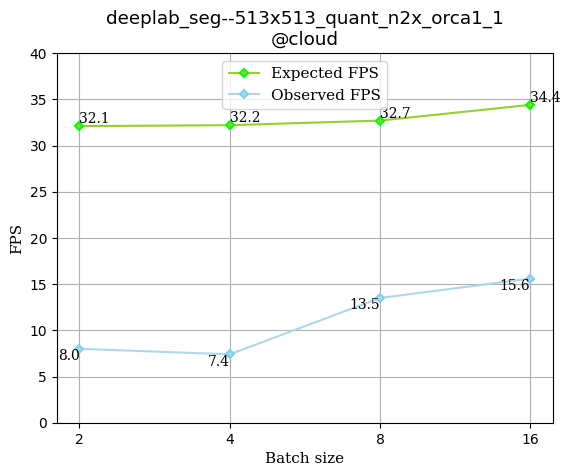

In [8]:
import importlib
importlib.reload(putil)
importlib.reload(pmes)

test_cycles = 1

iterations = 100
#iterations = 10

model_symbols = ['segmentation']  
model_names = [segmentation_model]
zoo_names = [segmentation_zoo]

# model_symbols = ['person_det', 'segmentation']  
# model_names = [person_det_model, segmentation_model]
# zoo_names = [person_det_zoo, segmentation_zoo]

model_instances = []
model_name_disps = []
observed_fps = {}
expected_fps = {}
device_temp = {}
items_dic = {}

for model_name in model_names:
    disp = model_name.replace('/home/gotom/model_zoo/', '')
    model_name_disps.append(disp)

model_instances = putil.create_model_instances(model_names, zoo_names, use_jpeg)

arr_save = False
d = time.strftime('%m%d%H%M') 
suffix_org = 'single'
file = data_dir + 'test_results(single_model)' + d + '.txt'
   
for i in range(len(model_name_disps)):

    items_dic['mode'] = 'Single model'
    items_dic['Device'] = target
    items_dic['iterations'] = iterations
    items_dic['model_name1'] = ''
    items_dic['model_name2'] = ''
    items_dic['image_file_name'] = image_file_name

    for batch in batch_sizes: 
        suffix = suffix_org + '(' + str(batch) + ')'

        if model_symbols[i] == 'segmentation':
            ymax = 40
        else:
            ymax = 160
        
    
        results = pmes.baseline_fps_measure(data_dir, test_cycles, iterations, model_name_disps[i], model_instances[i], image_file, \
                            exclude_preprocessing, batch, model_symbols[i], suffix, False)


        observed_fps[batch] = results['observed_fps']
        expected_fps[batch] = results['expected_fps']
        #device_temp[batch] = results['device_temp']
    
    items_dic['mode'] = 'Single model'
    items_dic['Device'] = target
    items_dic['iterations'] = iterations
    items_dic['model_name1'] = model_name_disps[i]
    items_dic['model_name2'] = ''
    items_dic['image_file_name'] = image_file_name    

    putil.show_results(items_dic, expected_fps, observed_fps)
    
    if i == 0:
        file_obj = open(file, 'w', encoding = 'utf-8')
    
    else:
        file_obj = open(file, 'a', encoding = 'utf-8')
    
    putil.save_results(file_obj, items_dic, expected_fps, observed_fps)
        
    model_name_str = items_dic["model_name1"] + '\n' + target   
    putil.draw_graph(data_dir, model_name_str, model_symbols[i], batch_strs, observed_fps, expected_fps, device_temp, ymax, suffix)

